# Capture RGBD 2D Snapshots from 3D Scenes and Project them Back to 3D

This notenbook contains the following topics:

- [Capture RGB and Depth Map Snapshots of a 3D Object](#capture-rgb-and-depth-map-snapshots-of-a-3d-object)
- [Reconstruct Pointcloud from RGB + Depth Map + Camera Parameters](#reconstruct-pointcloud-from-rgb--depth-map--camera-parameters)
- [Viewpoint Optimization](#viewpoint-optimization)

In [76]:
import pathlib
import open3d

In [25]:
def load_mesh(obj_path: str|pathlib.Path) -> open3d.geometry.TriangleMesh:
    mesh = open3d.io.read_triangle_mesh(obj_path, enable_post_processing=True)  # Load the OBJ file with TEXTURE!
    return mesh

In [26]:
def visualize_obj_file(obj_path: str) -> None:
    mesh = load_mesh(obj_path)
    if mesh.is_empty():
        raise ValueError(f"Failed to load the OBJ file at {obj_path}. The mesh is empty.")

    open3d.visualization.draw_geometries([mesh]) 


In [27]:
# Path to the OBJ file
obj_file = "../models/ikea_cup_reality_scan_iphone/Cup.obj"

# Visualize the OBJ
visualize_obj_file(obj_file)

## Capture RGB and Depth Map Snapshots of a 3D Object

In [41]:
import numpy as np
from typing import Tuple, Dict
from matplotlib import pyplot as plt


def capture_snapshot_from_mesh(
    mesh: open3d.geometry.TriangleMesh,
    focus_point: np.ndarray,
    up_axis: np.ndarray,
    zoom_factor: float = 1.0,
    width: int = 1080,
    height: int = 1080,
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """
    Capture an RGB and depth snapshot from a mesh, along with camera parameters.

    Args:
        mesh (o3d.geometry.TriangleMesh): The 3D mesh to render.
        focus_point (np.ndarray): The point to focus on.
        up_axis (np.ndarray): The up axis direction.
        zoom_factor (float, optional): Zoom factor. Defaults to 1.0.
        width (int, optional): Image width. Defaults to 1080.
        height (int, optional): Image height. Defaults to 1080.

    Returns:
        Tuple:
            - RGB image (np.ndarray)
            - Depth image (np.ndarray)
            - Camera parameters (dict)
    """

    # Create visualizer
    vis = open3d.visualization.Visualizer()
    vis.create_window(visible=False, width=width, height=height)
    vis.add_geometry(mesh)

    # Compute camera parameters
    def _compute_camera_params(vis, focus_point, up_axis, zoom_factor):
        view_control = vis.get_view_control()

        # Compute front vector (camera optical axis)
        front_vector = -np.cross(up_axis, [1, 0, 0])
        front_vector /= np.linalg.norm(front_vector)

        # Compute zoom
        bounds = mesh.get_axis_aligned_bounding_box()
        min_bound, max_bound = bounds.min_bound, bounds.max_bound
        diag_length = np.linalg.norm(max_bound - min_bound)
        zoom = zoom_factor / diag_length

        # Apply parameters
        view_control.set_front(front_vector)
        view_control.set_up(up_axis)
        view_control.set_zoom(zoom)
        view_control.set_lookat(focus_point)

        return view_control.convert_to_pinhole_camera_parameters()

    camera_params = _compute_camera_params(vis, focus_point, up_axis, zoom_factor)

    # Update renderer
    vis.poll_events()
    vis.update_renderer()

    # Capture RGB image
    rgb_image = np.asarray(vis.capture_screen_float_buffer(do_render=True)) * 255
    rgb_image = rgb_image.astype(np.uint8)

    # Capture depth image
    depth_image = np.asarray(vis.capture_depth_float_buffer(do_render=True)).astype(np.float32)
    # WARNING: if we want to save the depth image, we need to convert it to a 16-bit image
    #   depth_normalized = 65535 * (depth_image - depth_min) / (depth_max - depth_min)
    #   depth_normalized = depth_normalized.astype(np.uint16)
    #   depth_image_pil = Image.fromarray(depth_normalized)
    #   depth_image_pil.save(str(depth_filename))
    # Then, for loading:
    #   depth_image = Image.open(str(depth_path))
    #   depth_array = np.asarray(depth_image).astype(np.float32)
    #   depth_array = depth_min + (depth_array / 65535) * (depth_max - depth_min)

    # Extract camera intrinsic/extrinsic
    params = {
        "camera_intrinsic": camera_params.intrinsic.intrinsic_matrix,
        "width": camera_params.intrinsic.width,
        "height": camera_params.intrinsic.height,
        "camera_extrinsic": camera_params.extrinsic,
        "up_axis": up_axis.tolist(),
        "viewpoint": focus_point.tolist(),
        "zoom_factor": zoom_factor,
        "depth_max": depth_image.max(),
        "depth_min": depth_image.min(),
    }

    # Destroy visualizer
    vis.destroy_window()

    return rgb_image, depth_image, params


In [42]:
obj_file = "../models/ikea_cup_reality_scan_iphone/Cup.obj"
mesh = load_mesh(obj_file)
focus_point = mesh.get_center()

rgb_image, depth_image, params = capture_snapshot_from_mesh(
    mesh=mesh,
    focus_point=focus_point,
    up_axis=np.array([0.0, 1.0, 0.0]),
    zoom_factor=0.5,
    width=1080,
    height=1080,
)

In [43]:
def visualize_image(image: np.ndarray) -> None:
    plt.figure(figsize=(10, 10))
    if len(image.shape) == 2:  # Check if the image has only one channel
        min_val, max_val = image.min(), image.max()
        if min_val == 0 and max_val == 1:
            # mask
            plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        else:
            plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.axis("off")
    plt.show()

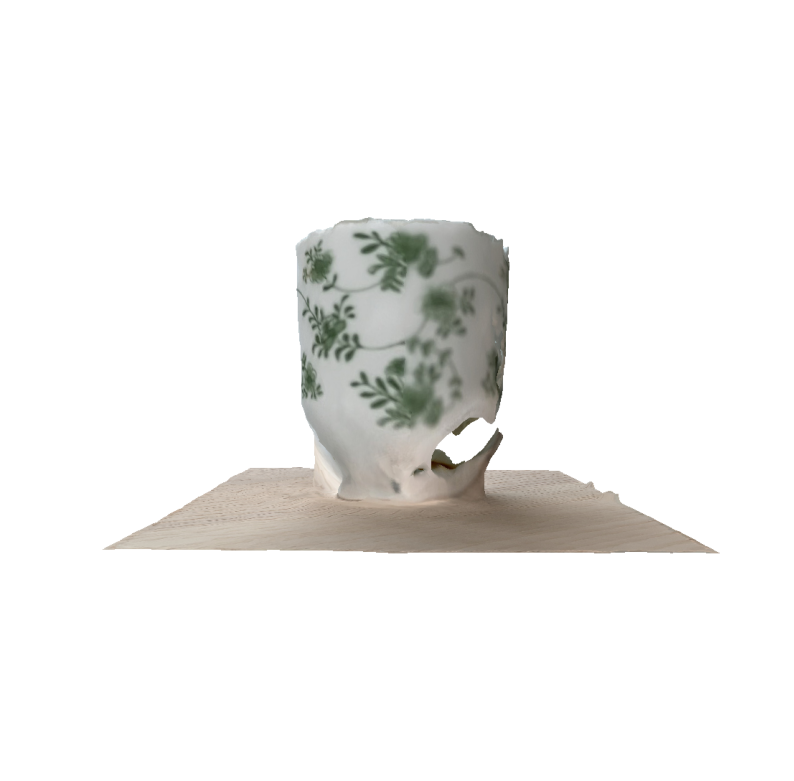

In [44]:
visualize_image(rgb_image)

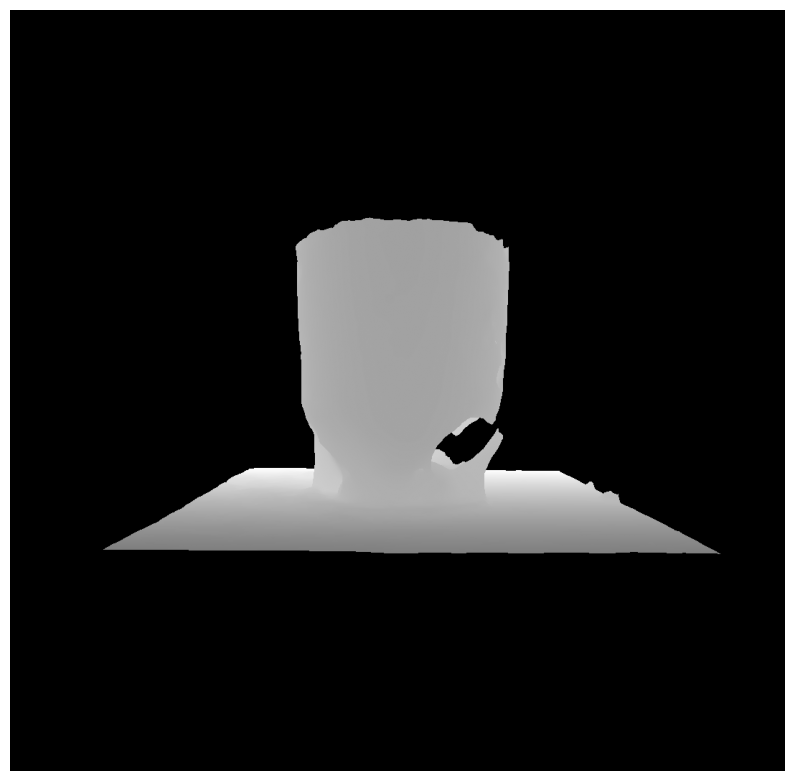

In [45]:
visualize_image(depth_image)

In [46]:
print(params)

{'camera_intrinsic': array([[918.85295342,   0.        , 539.5       ],
       [  0.        , 918.85295342, 530.        ],
       [  0.        ,   0.        ,   1.        ]]), 'width': 1080, 'height': 1061, 'camera_extrinsic': array([[ 1.        , -0.        ,  0.        ,  0.00827074],
       [-0.        , -1.        , -0.        , -1.20357739],
       [ 0.        ,  0.        , -1.        ,  1.57621212],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'up_axis': [0.0, 1.0, 0.0], 'viewpoint': [-0.008270735866555553, -1.2035773917057186, 0.9932165269318296], 'zoom_factor': 0.5, 'depth_max': np.float32(0.7778463), 'depth_min': np.float32(0.0)}


## Reconstruct Pointcloud from RGB + Depth Map + Camera Parameters

In [47]:
def reconstruct_point_cloud(
    rgb_o3d: open3d.geometry.Image | np.ndarray,
    depth_o3d: open3d.geometry.Image  | np.ndarray,
    params: Dict,
    visualize: bool = False,
):
    """Reconstruct a point cloud from a RGB & Depth image pair, as well as camera parameters.

    Args:
        rgb_o3d: The RGB image as an Open3D Image or numpy array.
            If numpy array, must be of shape (H, W, 3) and dtype uint8.
            It will be converted to Open3D Image.
        depth_o3d: The depth image as an Open3D Image or numpy array.
            If numpy array, must be of shape (H, W) and dtype float16/32.
            It will be converted to Open3D Image.
        params: The camera parameters as a dictionary.
            It must contain the following keys:
            - width: The image width.
            - height: The image height.
            - camera_intrinsic: The camera intrinsic matrix (3x3).
            - camera_extrinsic: The camera extrinsic matrix (4x4).
            - depth_max: The maximum depth value.
        visualize: Whether to visualize the point cloud using Open3D.

    Returns:
        open3d.geometry.PointCloud: The reconstructed point cloud as an Open3D PointCloud
    """
    # Convert images, if necessary
    if isinstance(rgb_o3d, np.ndarray):
        rgb_o3d = np.asarray(rgb_o3d).astype(np.uint8)
        rgb_o3d = open3d.geometry.Image(rgb_o3d)
    if isinstance(depth_o3d, np.ndarray):
        depth_o3d = np.asarray(depth_o3d).astype(np.float32)
        depth_o3d = open3d.geometry.Image(depth_o3d)

    # Extract parameters
    camera_extrinsic = params["camera_extrinsic"]
    camera_intrinsic = params["camera_intrinsic"]
    depth_max = params["depth_max"]
    width = params["width"]
    height = params["height"]

    # Create Open3D intrinsic matrix
    intrinsic_matrix = camera_intrinsic
    intrinsic = open3d.camera.PinholeCameraIntrinsic()
    intrinsic.set_intrinsics(
        width=width,
        height=height,
        fx=intrinsic_matrix[0][0],
        fy=intrinsic_matrix[1][1],
        cx=intrinsic_matrix[0][2],
        cy=intrinsic_matrix[1][2],
    )

    # Create extrinsic matrix
    extrinsic_matrix = np.array(camera_extrinsic)

    # Generate point cloud
    # Use create_from_depth_image if no RGB image available
    point_cloud = open3d.geometry.PointCloud.create_from_rgbd_image(
        open3d.geometry.RGBDImage.create_from_color_and_depth(
            color=rgb_o3d,
            depth=depth_o3d,
            depth_scale=1.0,  # Already in meters
            depth_trunc=depth_max,  # Truncate at max depth
            convert_rgb_to_intensity=False,
        ),
        intrinsic,
        extrinsic=extrinsic_matrix,
    )

    if visualize:
        open3d.visualization.draw_geometries([point_cloud])

    return point_cloud

In [48]:
reconstruct_point_cloud(rgb_image, depth_image, params, visualize=True)

PointCloud with 166947 points.

![Reconstructed Pointcloud](../assets/2d3d_reconstruction.png)

## Viewpoint Optimization

The following is an approximative heuristic to get a set of viewpoints that optimally cover the complete model.

Indeed it is not enough with being able to run a 3D-2D-3D projection, but we need to know how to navigate the scene and get the optimum set of viewpoints to capture the scene!

The presented method is not thoroughly debugged!

Idea:

- Get an initial set of viewpoints by projecting outwards the voxel centers of a coarse voxel grid.
- Create a finer voxel grid and go through the initial set of viewpoints in a loop:
  1. Each loop iteration, compute the priority map: how many fine voxel centers are seen if the camera is set in a viewpoint of the initial set
  2. Pick the viewpoint with highest fine voxel count
  3. Mark all fine voxels as seen
  4. Store viewpoint
  5. Next iteration (step 1)
- Loop finishes when all fine voxel centers have been seen.

In [67]:
import numpy as np
import open3d as o3d
from typing import List, Tuple, Optional

RELATIVE_TOLERANCE = 1e-1
ABSOLUTE_TOLERANCE = 1e-6

def compute_initial_viewpoints(
    mesh: o3d.geometry.TriangleMesh,
    voxel_size: float,
    margin_factor: float = 0.1,
    visualize: bool = False
) -> List[np.ndarray]:
    """
    Compute initial viewpoint candidates by projecting coarse voxel grid centers onto the AABB walls.

    Args:
        mesh (o3d.geometry.TriangleMesh): The 3D mesh to analyze.
        voxel_size (float): The size of the coarse voxel grid.
        margin (float, optional): Additional distance factor to project outside the AABB; multiplied to voxel_size.
            Defaults to 0.1.
        visualize (bool, optional): Whether to visualize the mesh and voxel centers. Defaults to False.

    Returns:
        List[np.ndarray]: The initial viewpoint positions.
    """
    # Compute coarse voxel grid
    point_cloud = mesh.sample_points_uniformly(number_of_points=100_000)
    coarse_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_cloud, voxel_size=voxel_size)
    
    # Get voxel centers
    voxel_centers = np.array([
        coarse_voxel_grid.get_voxel_center_coordinate(voxel.grid_index)
        for voxel in coarse_voxel_grid.get_voxels()
    ])
    
    # Compute AABB
    aabb = mesh.get_axis_aligned_bounding_box()
    min_bound, max_bound = aabb.min_bound, aabb.max_bound
    
    # Project voxel centers to the six walls of the AABB
    projected_centers = []
    for point in voxel_centers:
        for axis in range(3):  # Project onto each of the 6 AABB walls
            for bound in [min_bound, max_bound]:
                projected_point = point.copy()
                projected_point[axis] = bound[axis] + (margin_factor*voxel_size) * np.sign(point[axis] - bound[axis])
                projected_centers.append(projected_point)
    
    projected_centers = np.array(projected_centers)
    
    # Remove redundant points that are too close
    unique_viewpoints = []
    for point in projected_centers:
        if all(np.linalg.norm(point - vp) > RELATIVE_TOLERANCE * voxel_size for vp in unique_viewpoints):
            unique_viewpoints.append(point)
    
    if visualize:
        radius = 0.1 * voxel_size
        objects = [mesh]
        for point in unique_viewpoints:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
            sphere.translate(point)
            sphere.paint_uniform_color([0, 0, 1])  # Blue color for voxel centers
            objects.append(sphere)
        o3d.visualization.draw_geometries(objects)
    
    return unique_viewpoints

In [68]:
obj_file = "../models/ikea_cup_reality_scan_iphone/Cup.obj"
mesh = load_mesh(obj_file)

viewpoints = compute_initial_viewpoints(mesh=mesh, voxel_size=0.25, margin_factor=2.0, visualize=True)

In [74]:
def optimize_viewpoints(
    mesh: o3d.geometry.TriangleMesh,
    voxel_size: float,
    visualize: bool = False,
    initial_viewpoints: Optional[List[np.ndarray]] = None,
) -> List[np.ndarray]:
    """
    Optimize the viewpoint selection to minimize the number of captures needed to cover the scene.

    Args:
        mesh (o3d.geometry.TriangleMesh): The 3D mesh.
        voxel_size (float): The size of the fine voxel grid used to check visibility.
        initial_viewpoints (List[np.ndarray]): List of initial viewpoint positions.
            If None, will be computed automatically. Defaults to None.

    Returns:
        List[np.ndarray]: The optimized viewpoints.
    """
    def _get_viewpoint_camera_params(
        viewpoint: np.ndarray,
        extent: np.ndarray,
        width: int = 1080,
        height: int = 1080,
        up_vector: np.ndarray = np.array([0.0, 1.0, 0.0]),
        zoom_factor: float = 1.0,
    ) -> o3d.camera.PinholeCameraParameters:
        """Generate camera parameters for a given viewpoint."""
        # Visualizer
        visualizer = open3d.visualization.Visualizer()
        visualizer.create_window(visible=False, width=width, height=height)

        # Compute front vector
        # If up is -Y -> front is -Z
        front_vector = np.array([0.0, 0.0, -1.0])
        # If up is Z -> front is -Y
        if abs(np.dot(up_vector, np.array([0.0, 0.0, 1.0]))) > 1.0 - ABSOLUTE_TOLERANCE:
            front_vector = np.array([0.0, -1.0, 0.0])

        # Compute zoom based on the bounding box size
        # Zoom level (FOV changes): how much of the surrounding area (around viewpoint) is captured
        diag_length = np.linalg.norm(extent)
        zoom = zoom_factor / diag_length

        # Apply parameters
        view_control = visualizer.get_view_control()
        view_control.set_front(front_vector)
        view_control.set_up(up_vector)
        view_control.set_zoom(zoom)
        view_control.set_lookat(viewpoint)
        
        # Get camera parameters
        camera_params = view_control.convert_to_pinhole_camera_parameters()

        return camera_params
    
    def _is_point_visible(
        point: np.ndarray,
        camera_params: o3d.camera.PinholeCameraParameters,
        depth_min: float = 0.01,
        depth_max: float = 10.0,
    ) -> bool:
        """Check if a fine voxel center is visible from a viewpoint."""
        intrinsic_matrix = camera_params.intrinsic.intrinsic_matrix
        extrinsic_matrix = camera_params.extrinsic
        
        point_camera = extrinsic_matrix @ np.append(point, 1.0)
        if point_camera[2] <= 0:
            return False
        
        point_image = intrinsic_matrix @ point_camera[:3]
        x = point_image[0] / point_image[2]
        y = point_image[1] / point_image[2]
        
        width, height = camera_params.intrinsic.width, camera_params.intrinsic.height
        if not (0 <= x < width and 0 <= y < height):
            return False
        
        return depth_min <= point_camera[2] <= depth_max

    # Get initial viewpoints
    if initial_viewpoints is None:
        initial_viewpoints = compute_initial_viewpoints(mesh, voxel_size=voxel_size*3.0, margin_factor=1.0, visualize=False)
        
    # Compute fine voxel grid
    point_cloud = mesh.sample_points_uniformly(number_of_points=100_000)
    fine_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_cloud, voxel_size=voxel_size)
    fine_voxel_centers = np.array([
        fine_voxel_grid.get_voxel_center_coordinate(voxel.grid_index)
        for voxel in fine_voxel_grid.get_voxels()
    ])
    
    # Initialize optimization
    covered_mask = np.zeros(len(fine_voxel_centers), dtype=bool)
    viewpoints = []
    extent = mesh.get_max_bound() - mesh.get_min_bound()
    
    while not np.all(covered_mask):
        visibility_counts = np.zeros(len(initial_viewpoints))
        for i, vp in enumerate(initial_viewpoints):
            camera_params = _get_viewpoint_camera_params(viewpoint=vp, extent=extent)
            visibility_counts[i] = np.sum([
                not covered_mask[j] and _is_point_visible(fine_voxel_centers[j], camera_params)
                for j in range(len(fine_voxel_centers))
            ])
        
        best_idx = np.argmax(visibility_counts)
        best_viewpoint = initial_viewpoints.pop(best_idx)
        viewpoints.append(best_viewpoint)
        
        camera_params = _get_viewpoint_camera_params(viewpoint=best_viewpoint, extent=extent)
        for j in range(len(fine_voxel_centers)):
            if not covered_mask[j] and _is_point_visible(fine_voxel_centers[j], camera_params):
                covered_mask[j] = True
        
        if visibility_counts[best_idx] == 0:
            break

    if visualize:
        radius = 0.1 * voxel_size
        objects = [mesh]
        for point in viewpoints:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
            sphere.translate(point)
            sphere.paint_uniform_color([0, 1, 0])  # Green color for voxel centers
            objects.append(sphere)
        o3d.visualization.draw_geometries(objects)
    
    return viewpoints

In [75]:
viewpoints = optimize_viewpoints(
    mesh=mesh,
    voxel_size=0.1,
    visualize=True,
)